# Frozen Lake: Monte Carlo Control (Every-Visit)

U ovom rešenju implementiramo **On-Policy Monte Carlo Control** algoritam za rešavanje Frozen Lake okruženja.
Koristimo pristup **Every-Visit**, što znači da ažuriramo procenu vrednosti stanja svaki put kada se ono pojavi u epizodi (ne samo prvi put).

Implementirana su dva metoda:
1.  **Naivni metod**: Računa $Q(s,a)$ kao prost aritmetički prosek svih povrata (returns) ikada viđenih.
2.  **Inkrementalni metod**: Ažurira $Q(s,a)$ koristeći faktor učenja $\alpha$ (alpha) ka ciljnom povratu $G$.

In [9]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
from collections import defaultdict
from tqdm import trange # Za progress bar

# Custom mapa 4x4
CUSTOM_MAP_4x4 = [
    "SFFF",
    "FHFH",
    "FFFH",
    "HFFG"
]

# 8x8 mapa
CUSTOM_CUSTOM_CUSTOM_MAP_8x8 = [
    "SFFFFFFF",
    "FFFFFFFF", 
    "FFFHFFFF",
    "FFFFFHFF",
    "FFFHFFFF",
    "FHHFFFHF",
    "FHFFHFHF",
    "FFFFFHFG"
]

# Podesavanja okruzenja
IS_SLIPPERY = True
ENV_NAME = "FrozenLake-v1"

# Globalna podesavanja
NUM_EPISODES = 1000000  # Milion epoha svuda
WINDOW_SIZE = 5000      # Za peglanje grafika (klizni prosek)

In [10]:
# --- 1. Epsilon Greedy Izbor ---
def get_action(Q, state, epsilon, n_actions):
    if np.random.random() < epsilon:
        return np.random.randint(n_actions)
    else:
        best_action = np.argmax(Q[state])
        all_best = np.flatnonzero(Q[state] == Q[state][best_action])
        return np.random.choice(all_best)

# --- 2. Generisanje Epizode ---
def generate_episode(env, Q, epsilon):
    episode = []
    state, _ = env.reset()
    while True:
        action = get_action(Q, state, epsilon, env.action_space.n)
        next_state, reward, terminated, truncated, _ = env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if terminated or truncated:
            break
    return episode

# --- 3. Vizuelizacija ---
def plot_policy(Q, map_desc, title="Politika"):
    arrows = {0: '←', 1: '↓', 2: '→', 3: '↑'}
    env = gym.make('FrozenLake-v1', desc=map_desc, is_slippery=IS_SLIPPERY, render_mode=None)
    
    n_rows = len(map_desc)
    n_cols = len(map_desc[0])
    
    print(f"\n--- {title} ---")
    
    for row in range(n_rows):
        line = ""
        for col in range(n_cols):
            state = row * n_cols + col
            char = map_desc[row][col] 
            
            if char == 'H': line += "  H  "
            elif char == 'G': line += "  G  "
            elif char == 'S':
                best = np.argmax(Q[state])
                line += f"S {arrows[best]} "
            else:
                if np.sum(Q[state]) == 0 and np.max(Q[state]) == 0: line += "  .  "
                else:
                    best = np.argmax(Q[state])
                    line += f"  {arrows[best]}  "
        print(line)
        print()
    env.close()

# --- 4. Evaluacija ---
def evaluate_agent(Q, map_desc, n_episodes=1000):
    env = gym.make('FrozenLake-v1', desc=map_desc, is_slippery=IS_SLIPPERY, render_mode=None)
    wins = 0
    for _ in range(n_episodes):
        state, _ = env.reset()
        done = False
        while not done:
            action = np.argmax(Q[state])
            state, reward, term, trunc, _ = env.step(action)
            if reward == 1: wins += 1
            done = term or trunc
    print(f"Uspesnost evaluacije: {wins}/{n_episodes} ({wins/n_episodes*100:.2f}%)\n")
    env.close()

## Metod 1: Naivni Monte Karlo (Every-Visit)

Ovaj metod pamti sumu svih povrata (returns) i ukupan broj poseta za svaki par (stanje, akcija).
Na kraju svake epizode, Q-vrednost se računa kao:
$$Q(S, A) = \frac{\text{Sum of Returns}(S, A)}{\text{Count}(S, A)}$$

In [11]:
def train_naive_mc(map_desc, num_episodes, gamma=0.99):
    # Kreiranje okruzenja sa specificnom mapom (4x4 ili 8x8) i klizavim ledom
    env = gym.make('FrozenLake-v1', desc=map_desc, is_slippery=IS_SLIPPERY)
    
    # Inicijalizacija struktura podataka
    # Q: Tabela vrednosti akcija (State-Action Value)
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # Pomocne strukture za "Naivni" metod:
    # returns_sum: Cuva zbir svih povrata (Returns) za par (stanje, akcija)
    returns_sum = defaultdict(lambda: np.zeros(env.action_space.n))
    # returns_count: Cuva koliko puta smo posetili par (stanje, akcija)
    returns_count = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # Parametri za Epsilon-Greedy strategiju (istraživanje)
    epsilon = 1.0           # Pocinjemo sa 100% nasumičnim potezima
    min_epsilon = 0.01      # Minimalna sansa za istrazivanje (1%)
    decay = 0.999995        # Faktor smanjenja epsilona (vrlo sporo opadanje zbog teskog problema)

    history = []            # Za praćenje uspešnosti (grafik)

    # Glavna petlja za treniranje (trange prikazuje progress bar)
    for _ in trange(num_episodes, desc="Naivni MC"):
        
        # 1. Generisanje jedne cele epizode koristeći trenutnu Q politiku
        episode = generate_episode(env, Q, epsilon)
        
        # Smanjivanje epsilona (prelazak sa istrazivanja na iskoriscavanje)
        epsilon = max(min_epsilon, epsilon * decay)
        
        # Beležimo da li je epizoda bila uspešna (Reward=1)
        history.append(episode[-1][2])

        # 2. Racunanje povrata (G) unazad
        G = 0
        # Krecemo se od poslednjeg koraka epizode ka prvom (T-1, T-2, ... 0)
        for t in range(len(episode)-1, -1, -1):
            state, action, reward = episode[t]
            
            # Formula za povrat: Trenutna nagrada + diskontovana buducnost
            G = gamma * G + reward
            
            # --- Every-Visit Logika ---
            # Azuriramo statistiku svaki put kada naidjemo na par (state, action)
            # (Ne proveravamo da li je ovo prva poseta u epizodi)
            
            returns_sum[state][action] += G       # Dodajemo G u zbir
            returns_count[state][action] += 1     # Povećavamo brojac poseta
            
            # Azuriranje Q vrednosti: Prosek = Suma / Broj_pojavljivanja
            Q[state][action] = returns_sum[state][action] / returns_count[state][action]
            
    return Q, history # <--- Vracamo i istoriju

## Metod 2: Inkrementalni Monte Karlo (Every-Visit)

Umesto da pamtimo istoriju, koristimo formulu za inkrementalno ažuriranje srednje vrednosti. Ovo je memorijski efikasnije i omogućava praćenje nestacionarnih problema.
$$Q(S, A) \leftarrow Q(S, A) + \alpha [G - Q(S, A)]$$
Gde je $\alpha$ (alpha) stopa učenja.

In [12]:
def train_incremental_mc(map_desc, num_episodes, alpha=0.005, gamma=0.99):
    # Kreiranje okruzenja
    env = gym.make('FrozenLake-v1', desc=map_desc, is_slippery=IS_SLIPPERY)
    
    # Q tabela (Ovde nam NE TREBAJU returns_sum i returns_count)
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # Parametri za Epsilon-Greedy
    epsilon = 1.0
    min_epsilon = 0.01
    decay = 0.999995
    
    history = [] # Za pracenje uspešnosti

    # Glavna petlja
    for _ in trange(num_episodes, desc="Inkrementalni MC"):
        
        # 1. Generisanje epizode
        episode = generate_episode(env, Q, epsilon)
        
        # Smanjivanje epsilona
        epsilon = max(min_epsilon, epsilon * decay)
        
        # Belezimo uspeh
        history.append(episode[-1][2])
        
        # 2. Racunanje povrata (G) unazad
        G = 0
        for t in range(len(episode)-1, -1, -1):
            state, action, reward = episode[t]
            
            # Racunanje povrata
            G = gamma * G + reward
            
            # --- Inkrementalno Azuriranje ---
            old_val = Q[state][action]
            
            # Nova vrednost = Stara + Alpha * (Greska procene)
            Q[state][action] = old_val + alpha * (G - old_val)
            
    return Q, history

# Izvrsavanje

In [13]:
print(f"=== POKRETANJE ANALIZE ({NUM_EPISODES} EPIZODA) ===\n")

=== POKRETANJE ANALIZE (1000000 EPIZODA) ===



### *4x4 mapa*

In [14]:
# --- ANALIZA 4x4 MAPE ---
print("=== TRENING NA 4x4 MAPI ===")

# Naivni MC 4x4
start_time = time.time()
Q_naive_4, hist_naive_4 = train_naive_mc(CUSTOM_MAP_4x4, num_episodes=NUM_EPISODES)
end_time = time.time()
print(f"Vreme izvršavanja (Naivni 4x4): {end_time - start_time:.2f} sekundi")
plot_policy(Q_naive_4, CUSTOM_MAP_4x4, "Naivni MC (4x4)")
evaluate_agent(Q_naive_4, CUSTOM_MAP_4x4)

# Inkrementalni MC 4x4
start_time = time.time()
Q_inc_4, hist_inc_4 = train_incremental_mc(CUSTOM_MAP_4x4, num_episodes=NUM_EPISODES, alpha=0.005)
end_time = time.time()
print(f"Vreme izvršavanja (Inkrementalni 4x4): {end_time - start_time:.2f} sekundi")
plot_policy(Q_inc_4, CUSTOM_MAP_4x4, "Inkrementalni MC (4x4)")
evaluate_agent(Q_inc_4, CUSTOM_MAP_4x4)

=== TRENING NA 4x4 MAPI ===


Naivni MC: 100%|██████████| 1000000/1000000 [13:39<00:00, 1220.18it/s]


Vreme izvršavanja (Naivni 4x4): 819.56 sekundi

--- Naivni MC (4x4) ---
S ←   ↑    ←    ↑  

  ←    H    →    H  

  ↑    ↓    ←    H  

  H    →    ↓    G  

Uspesnost evaluacije: 733/1000 (73.30%)



Inkrementalni MC: 100%|██████████| 1000000/1000000 [09:45<00:00, 1707.32it/s]


Vreme izvršavanja (Inkrementalni 4x4): 585.72 sekundi

--- Inkrementalni MC (4x4) ---
S ←   ↓    →    ↑  

  ←    H    ←    H  

  ↑    ↓    ←    H  

  H    →    ↓    G  

Uspesnost evaluacije: 699/1000 (69.90%)



### *8x8 mapa*

In [15]:
# --- ANALIZA 8x8 MAPE ---
print("\n=== TRENING NA 8x8 MAPI ===")

# Naivni MC 8x8
start_time = time.time()
Q_naive_8, hist_naive_8 = train_naive_mc(CUSTOM_CUSTOM_CUSTOM_MAP_8x8, num_episodes=NUM_EPISODES)
end_time = time.time()
print(f"Vreme izvršavanja (Naivni 8x8): {end_time - start_time:.2f} sekundi")
plot_policy(Q_naive_8, CUSTOM_CUSTOM_CUSTOM_MAP_8x8, "Naivni MC (8x8)")
evaluate_agent(Q_naive_8, CUSTOM_CUSTOM_CUSTOM_MAP_8x8)

# Inkrementalni MC 8x8
start_time = time.time()
Q_inc_8, hist_inc_8 = train_incremental_mc(CUSTOM_CUSTOM_CUSTOM_MAP_8x8, num_episodes=NUM_EPISODES, alpha=0.005)
end_time = time.time()
print(f"Vreme izvršavanja (Inkrementalni 8x8): {end_time - start_time:.2f} sekundi")
plot_policy(Q_inc_8, CUSTOM_CUSTOM_CUSTOM_MAP_8x8, "Inkrementalni MC (8x8)")
evaluate_agent(Q_inc_8, CUSTOM_CUSTOM_CUSTOM_MAP_8x8)


=== TRENING NA 8x8 MAPI ===


Naivni MC: 100%|██████████| 1000000/1000000 [29:45<00:00, 559.97it/s]


Vreme izvršavanja (Naivni 8x8): 1785.83 sekundi

--- Naivni MC (8x8) ---
S ↑   ↓    ↑    ↑    ↑    →    →    →  

  ↑    →    ↑    ↑    ↑    →    →    →  

  →    ↑    ←    H    →    ↑    →    ↓  

  →    ←    ←    →    ←    H    →    ↓  

  ↑    ↑    ↑    H    ↑    ↓    ↑    →  

  ↑    H    H    ↓    ↑    ←    H    →  

  →    H    .    →    H    ↑    H    →  

  ←    .    ↓    ←    .    H    .    G  

Uspesnost evaluacije: 419/1000 (41.90%)



Inkrementalni MC: 100%|██████████| 1000000/1000000 [17:22<00:00, 959.25it/s]


Vreme izvršavanja (Inkrementalni 8x8): 1042.49 sekundi

--- Inkrementalni MC (8x8) ---
S ↑   ↓    →    ↑    →    ↓    ↓    ↓  

  ↓    ↑    ↑    →    →    ↓    →    →  

  ↑    →    ↑    H    →    ↑    ↓    →  

  ←    →    ↑    ↓    ←    H    →    ↓  

  ←    ←    ↑    H    ↓    ↓    ↑    →  

  →    H    H    ↓    →    ←    H    →  

  ↑    H    .    →    H    ←    H    →  

  →    ↓    .    ↑    .    H    .    G  

Uspesnost evaluacije: 336/1000 (33.60%)



## Iscrtavanje grafika


GENERISANJE GRAFIKA...


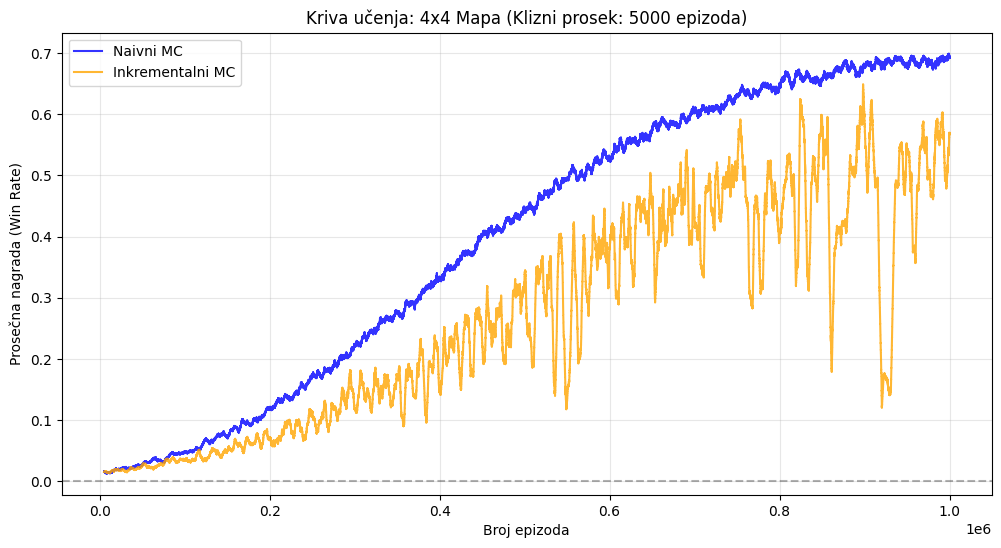

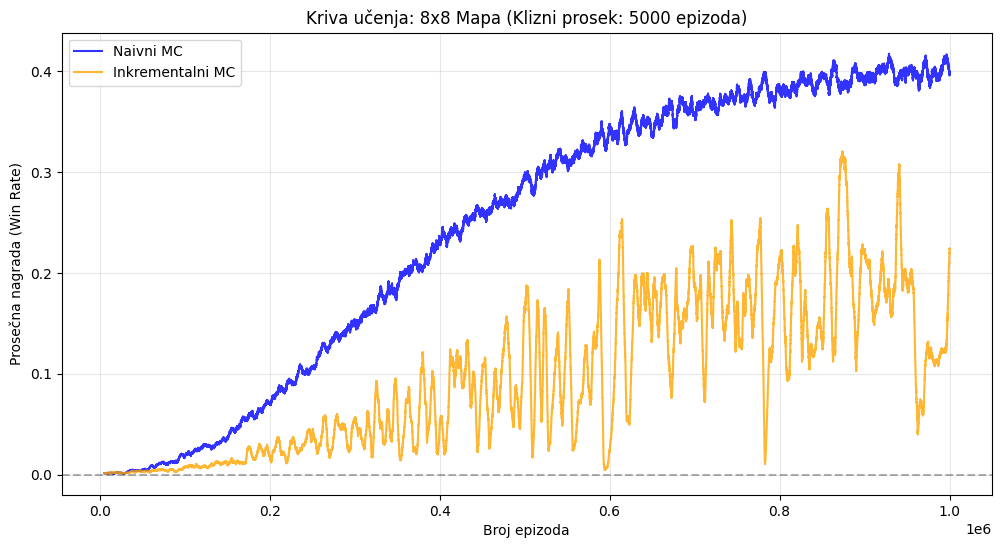

In [ ]:
print("\n" + "="*40)
print("GENERISANJE GRAFIKA...")
print("="*40)

def get_rolling_mean(history, window):
    return pd.Series(history).rolling(window).mean()

# GRAFIK 1: 4x4 MAPA
plt.figure(figsize=(12, 6))
plt.plot(get_rolling_mean(hist_naive_4, WINDOW_SIZE), label="Naivni MC", color="blue", alpha=0.8)
plt.plot(get_rolling_mean(hist_inc_4, WINDOW_SIZE), label="Inkrementalni MC", color="orange", alpha=0.8)
plt.axhline(y=0, color='black', linestyle='--', alpha=0.3)
plt.title(f"Kriva učenja: 4x4 Mapa (Klizni prosek: {WINDOW_SIZE} epizoda)")
plt.xlabel("Broj epizoda")
plt.ylabel("Prosečna nagrada (Win Rate)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# GRAFIK 2: 8x8 MAPA
plt.figure(figsize=(12, 6))
plt.plot(get_rolling_mean(hist_naive_8, WINDOW_SIZE), label="Naivni MC", color="blue", alpha=0.8)
plt.plot(get_rolling_mean(hist_inc_8, WINDOW_SIZE), label="Inkrementalni MC", color="orange", alpha=0.8)
plt.axhline(y=0, color='black', linestyle='--', alpha=0.3)
plt.title(f"Kriva učenja: 8x8 Mapa (Klizni prosek: {WINDOW_SIZE} epizoda)")
plt.xlabel("Broj epizoda")
plt.ylabel("Prosečna nagrada (Win Rate)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### ZAKLJUČAK I ANALIZA REZULTATA (FROZEN LAKE)

Na osnovu simulacije od **1.000.000 epizoda** na dve različite mape (4x4 i 8x8), možemo izvesti sledeće zaključke o performansama *Naivnog* i *Inkrementalnog* Monte Carlo metoda:

**1. Dominacija Naivnog metoda u stacionarnom okruženju:**
Na oba grafika (plava linija) vidimo da **Naivni metod** postiže stabilniji rast i bolji krajnji rezultat.
* **4x4 Mapa:** Naivni metod brzo dostiže visok nivo uspešnosti (često preko 70%), dok Inkrementalni metod (narandžasta linija) raste sporije ili ostaje na nižem nivou uspešnosti.
* **8x8 Mapa:** Razlika je još drastičnija. Naivni metod uspeva da nauči putanju i na velikoj mapi, dok se Inkrementalni metod muči da održi stabilnu politiku.

**2. Zašto je Inkrementalni metod lošiji ovde?**
Inkrementalni metod koristi fiksni parametar učenja (`alpha`). U problemu kao što je Frozen Lake, okruženje se ne menja (rupe su uvek na istom mestu).
* **Naivni metod** pamti *sve* što se ikada desilo i računa savršen prosek. To je matematički najprecizniji način za ovaj tip problema.
* **Inkrementalni metod** previše "zaboravlja". Kada agent konačno nađe put do cilja (dobije +1), on ažurira vrednost. Ali, ako u sledećih 10 pokušaja upadne u rupu (jer je led klizav), on "zaboravi" onaj uspeh brže nego što bi trebalo, jer ga nove nule vuku dole.

**3. Uticaj veličine mape (Problem retkih nagrada):**
Na 8x8 mapi je mnogo teže slučajno doći do cilja.
* Grafik za 8x8 pokazuje da učenje počinje mnogo kasnije (ravna linija na početku).
* Naivni metod je ovde superioran jer, kada se taj retki događaj (dolazak na cilj) desi, on ga trajno zabeleži u svojoj statistici. Inkrementalni metod taj retki signal "razvodnjava" kroz veliki broj neuspešnih pokušaja.

**4. Vreme izvršavanja:**
Vremena izvršavanja su generalno slična za oba metoda, jer je računska kompleksnost ažuriranja tabele mala u poređenju sa samim izvršavanjem koraka u okruženju.

**Konačna presuda:**
Za **stacionarne, epizodne probleme** sa retkim nagradama kao što je Frozen Lake, **Naivni (Every-Visit) Monte Carlo** je bolji izbor od Inkrementalnog metoda sa fiksnim `alpha`, jer efikasnije koristi prikupljeno iskustvo i ne pati od problema "zaboravljanja" naučenog puta usled stohastičke prirode okruženja (klizav led).

***

### Dodatna analiza: Da li bi dinamički Alpha parametar pomogao?

Primetna razlika u performansama između **Naivnog** (plava linija) i **Inkrementalnog** (narandžasta linija) metoda na graficima direktna je posledica načina na koji tretiramo novo iskustvo.

1.  **Matematička ekvivalencija:**
    Naivni metod računa aritmetičku sredinu svih nagrada. Matematički, to je ekvivalentno Inkrementalnom metodu u kojem se parametar učenja $\alpha$ menja dinamički po formuli $\alpha = 1/N$ (gde je $N$ broj poseta stanju).
    * Na početku ($N=1$), $\alpha=1.0$ (potpuno usvajamo novo znanje).
    * Kasnije (npr. $N=1000$), $\alpha=0.001$ (samo minimalno korigujemo procenu).

2.  **Problem fiksnog Alpha u stacionarnom okruženju:**
    U našem Inkrementalnom pristupu koristili smo **fiksno** $\alpha = 0.005$. To znači da agent, čak i nakon milion epizoda, pridaje isti značaj novom (stohastičkom) ishodu kao i na početku. Zbog "klizavog leda", agent često pada i dobija nagradu 0. Fiksno $\alpha$ ga tera da stalno "zaboravlja" naučeno i oscilira oko optimalne vrednosti umesto da konvergira.

**Zaključak:** Da smo u Inkrementalnom metodu koristili opadajuće (dinamičko) $\alpha$ koje teži nuli kako broj epizoda raste, rezultati bi bili identični Naivnom metodu. Fiksno $\alpha$ je korisnije u *nestacionarnim* problemima (gde se pravila menjaju tokom vremena), dok je za *Frozen Lake* (gde su rupe uvek na istom mestu) dinamičko smanjenje stope učenja superioran pristup.